In [1]:
%matplotlib inline


# Plotting data from a file

Plotting CPU usage values


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from glob import glob
from sklearn.metrics import auc

In [3]:
# numRecordsOutPrelim = \
#     pd.read_csv("taskmanager_job_task_operator_numRecordsOutPerSecond_traffic-based_2021_03_29.csv")
# numRecordsOutPrelim["time"] = pd.to_datetime(numRecordsOutPrelim["time"])
# # numRecordsOutPrelim
# numRecordsOutSummary = numRecordsOutPrelim.groupby(["time","host","operator_name","subtask_index"])\
#     .agg(lambda x : list(x))

Helper functions
===========================

In [4]:
def get_relative_time_in_mins(start_time, data):
    # relative_time = round((data - start_time).dt.total_seconds() / 60.0, 1)
    relative_time = data - start_time
    return relative_time

Function to load CPU data
=====================

In [5]:
def load_cpu_data_from_csv(user_offset=0, skip_offset_for_mode="default"):
    task_tot_cpu_filenames = glob("taskmanager_System_CPU_Usage_*.csv")
    n_schedule_types = len(task_tot_cpu_filenames)
    task_tot_cpu_data = [None] * n_schedule_types
    for idx, f in enumerate(task_tot_cpu_filenames):
        schedule_mode = f.split("_")[4]
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print("Reading " + f + " into index " + str(idx) +
              " ['" + schedule_mode + "']\n")
        task_tot_cpu_data[idx] = pd.read_csv(f)
        task_tot_cpu_data[idx]["schedule_mode"] = schedule_mode

    for cpu_usage_dataset in task_tot_cpu_data:
        start_offset = 0
        if cpu_usage_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            cpu_usage_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        cpu_usage_dataset["time"] = pd.to_datetime(
            cpu_usage_dataset["time"], unit="ns", utc=True
        )
        cpu_usage_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, cpu_usage_dataset["time"]
        )
        cpu_usage_dataset["formatted_time"] = cpu_usage_dataset["time"].dt.strftime(
            "%H:%M:%S"
        )

    # Read individual CPU data
    individual_cpu_filenames = glob("jobmanager_System_CPU_UsageCPU*.csv")
    individual_cpu_data = pd.DataFrame()
    schedule_modes = []
    for idx, f in enumerate(individual_cpu_filenames):
        individual_cpu_dataset = pd.read_csv(f)
        schedule_mode = f.split("_")[4]
        print("Reading " + f + " ['" + schedule_mode + "']")
        if schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
        individual_cpu_dataset["schedule_mode"] = schedule_mode
        schedule_modes.append(schedule_mode)

        start_offset = 0
        if individual_cpu_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            individual_cpu_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )

        individual_cpu_dataset["time"] = pd.to_datetime(
            individual_cpu_dataset["time"], unit="ns", utc=True
        )
        individual_cpu_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, individual_cpu_dataset["time"]
        )
        individual_cpu_dataset["formatted_time"] = individual_cpu_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

        cpu_id = individual_cpu_dataset.name.iloc[0].partition(
            "taskmanager_System_CPU_UsageCPU"
        )[-1]
        cpu_usage_name = "CPU " + cpu_id.rjust(2, "0") + " Usage"
        individual_cpu_dataset["cpu_id"] = int(cpu_id)
        individual_cpu_dataset["cpu_usage_name"] = cpu_usage_name
        if individual_cpu_data.empty:
            individual_cpu_data = individual_cpu_dataset
        else:
            individual_cpu_data = individual_cpu_data.append(individual_cpu_dataset)

    return task_tot_cpu_data, individual_cpu_data, set(schedule_modes)

Function to load operator data
=========================

In [6]:
def load_operator_data_from_csv(user_offset=0, skip_offset_for_mode="default"):
    task_operator_cpu_filenames = glob(
        "taskmanager_job_task_operator_currentCpuUsage_*.csv"
    )
    n_schedule_types = len(task_operator_cpu_filenames)
    task_operator_cpu_data = [None] * n_schedule_types
    for idx, f in enumerate(task_operator_cpu_filenames):
        schedule_mode = f.split("_")[5]
        print(schedule_mode)
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print(
            "Reading "
            + f
            + " into index "
            + str(idx)
            + " with schedule mode "
            + schedule_mode
        )
        task_operator_cpu_data[idx] = pd.read_csv(f)
        task_operator_cpu_data[idx]["schedule_mode"] = schedule_mode

    for operator_cpu_dataset in task_operator_cpu_data:
        start_offset = 0
        if operator_cpu_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            operator_cpu_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        operator_cpu_dataset["time"] = pd.to_datetime(
            operator_cpu_dataset["time"], unit="ns", utc=True
        )
        operator_cpu_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, operator_cpu_dataset["time"]
        )
        operator_cpu_dataset["formatted_time"] = operator_cpu_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

    task_operator_rec_in_filenames = glob(
        "taskmanager_job_task_operator_numRecordsInPerSecond_*.csv"
    )
    task_operator_rec_in_data = [None] * n_schedule_types
    for idx, f in enumerate(task_operator_rec_in_filenames):
        schedule_mode = f.split("_")[5]
        print(schedule_mode)
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print(
            "Reading "
            + f
            + " into index "
            + str(idx)
            + " with schedule mode "
            + schedule_mode
        )
        task_operator_rec_in_data[idx] = pd.read_csv(f)
        task_operator_rec_in_data[idx]["schedule_mode"] = schedule_mode

    for operator_rec_in_dataset in task_operator_rec_in_data:
        start_offset = 0
        if operator_rec_in_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            operator_rec_in_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        operator_rec_in_dataset["time"] = pd.to_datetime(
            operator_rec_in_dataset["time"], unit="ns", utc=True
        )
        operator_rec_in_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, operator_rec_in_dataset["time"]
        )
        operator_rec_in_dataset["formatted_time"] = operator_rec_in_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

    task_operator_rec_out_filenames = glob(
        "taskmanager_job_task_operator_numRecordsOutPerSecond_*.csv"
    )
    task_operator_rec_out_data = [None] * n_schedule_types
    for idx, f in enumerate(task_operator_rec_out_filenames):
        schedule_mode = f.split("_")[5]
        print(schedule_mode)
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print(
            "Reading "
            + f
            + " into index "
            + str(idx)
            + " with schedule mode "
            + schedule_mode
        )
        task_operator_rec_out_data[idx] = pd.read_csv(f)
        task_operator_rec_out_data[idx]["schedule_mode"] = schedule_mode

    for operator_rec_out_dataset in task_operator_rec_out_data:
        start_offset = 0
        if operator_rec_out_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            operator_rec_out_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        operator_rec_out_dataset["time"] = pd.to_datetime(
            operator_rec_out_dataset["time"], unit="ns", utc=True
        )
        operator_rec_out_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, operator_rec_out_dataset["time"]
        )
        operator_rec_out_dataset["formatted_time"] = operator_rec_out_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

    task_operator_rec_proc_filenames = glob(
        "taskmanager_job_task_operator_numRecordsProcessedPerSecond_*.csv"
    )
    task_operator_rec_proc_data = [None] * n_schedule_types
    for idx, f in enumerate(task_operator_rec_proc_filenames):
        schedule_mode = f.split("_")[5]
        print(schedule_mode)
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print(
            "Reading "
            + f
            + " into index "
            + str(idx)
            + " with schedule mode "
            + schedule_mode
        )
        task_operator_rec_proc_data[idx] = pd.read_csv(f)
        task_operator_rec_proc_data[idx]["schedule_mode"] = schedule_mode

    for operator_rec_proc_dataset in task_operator_rec_proc_data:
        start_offset = 0
        if operator_rec_proc_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            operator_rec_proc_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        operator_rec_proc_dataset["time"] = pd.to_datetime(
            operator_rec_proc_dataset["time"], unit="ns", utc=True
        )
        operator_rec_proc_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, operator_rec_proc_dataset["time"]
        )
        operator_rec_proc_dataset["formatted_time"] = operator_rec_proc_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

    return (
        task_operator_cpu_data,
        task_operator_rec_in_data,
        task_operator_rec_out_data,
        task_operator_rec_proc_data,
    )

In [7]:
task_tot_cpu_data, individual_cpu_data, schedule_modes = load_cpu_data_from_csv(0)
schedule_modes
# task_tot_cpu_data[1]

Reading taskmanager_System_CPU_Usage_default_2021_04_05.csv into index 0 ['default']

Reading taskmanager_System_CPU_Usage_traffic-based_2021_04_05.csv into index 1 ['traffic-based']

Reading jobmanager_System_CPU_UsageCPU17_traffic-based_2021_04_05.csv ['traffic-based']
Reading jobmanager_System_CPU_UsageCPU17_default_2021_04_05.csv ['default']
Reading jobmanager_System_CPU_UsageCPU7_default_2021_04_05.csv ['default']
Reading jobmanager_System_CPU_UsageCPU5_default_2021_04_05.csv ['default']
Reading jobmanager_System_CPU_UsageCPU3_default_2021_04_05.csv ['default']
Reading jobmanager_System_CPU_UsageCPU0_default_2021_04_05.csv ['default']
Reading jobmanager_System_CPU_UsageCPU0_traffic-based_2021_04_05.csv ['traffic-based']
Reading jobmanager_System_CPU_UsageCPU4_default_2021_04_05.csv ['default']
Reading jobmanager_System_CPU_UsageCPU8_default_2021_04_05.csv ['default']
Reading jobmanager_System_CPU_UsageCPU18_default_2021_04_05.csv ['default']
Reading jobmanager_System_CPU_UsageCPU1

{'default', 'traffic-based'}

In [8]:
list_data = (
    task_tot_cpu_data[0]
    .groupby([pd.Grouper(key="rel_time", freq="1min"), pd.Grouper(key="host")])["value"]
    .agg(lambda x: list(x))
)
# print(list_data.to_string() + "\n\n")

plot_data = (
    task_tot_cpu_data[0]
    .groupby([pd.Grouper(key="rel_time", freq="1min"), pd.Grouper(key="host")])["value"]
    .first()
    .groupby("rel_time")
    .sum()
    .reset_index()
)
plot_data["rel_time"] = plot_data["rel_time"].dt.seconds
plot_data.head()

,rel_time,value
0,0,101.0
1,60,595.0
2,120,752.0
3,180,764.0
4,240,882.0


In [9]:
for i in range(len(task_tot_cpu_data)):
    task_tot_cpu_data[i] = (
        task_tot_cpu_data[i]
        .groupby([pd.Grouper(key="rel_time", freq="1min"), pd.Grouper(key="host")])[
            "value"
        ]
        .first()
        .groupby("rel_time")
        .sum()
        .reset_index()
    )
    task_tot_cpu_data[i]["rel_time"] = task_tot_cpu_data[i]["rel_time"].dt.seconds
# task_tot_cpu_data[1].head()

Task Manager CPU Usage
-----------



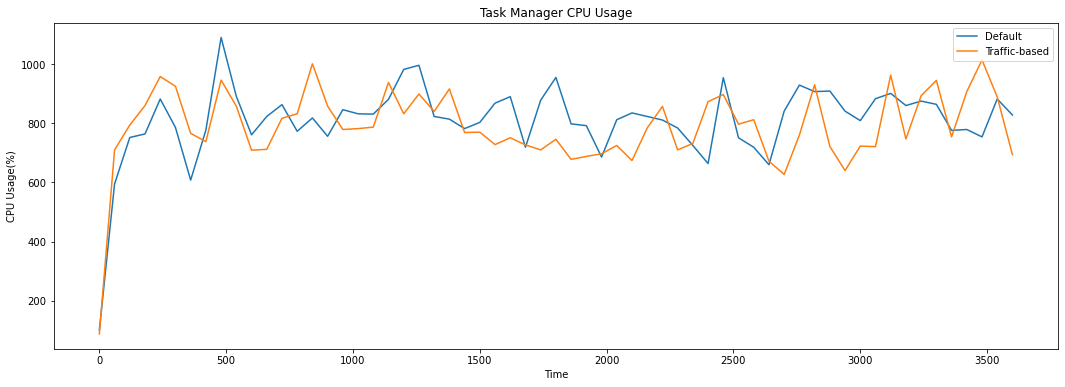

In [10]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(task_tot_cpu_data[0]["rel_time"], task_tot_cpu_data[0]["value"])
ax.plot(task_tot_cpu_data[1]["rel_time"], task_tot_cpu_data[1]["value"])
# ax.plot(task_tot_cpu_data[2]['rel_time'], task_tot_cpu_data[2]['value'])
# ax.plot(task_tot_cpu_data[3]['rel_time'], task_tot_cpu_data[3]['value'])

ax.set(xlabel="Time", ylabel="CPU Usage(%)", title="Task Manager CPU Usage")
ax.tick_params(axis="x", rotation=0)
ax.legend(
    ["Default", "Traffic-based", "Q Actor-Critic", "Actor-Critic NN"], loc="upper right"
)
plt.savefig("task_manager_cpu_usage.png")
plt.show()

In [11]:
individual_cpu_data.head()

,name,time,host,tm_id,value,schedule_mode,rel_time,formatted_time,cpu_id,cpu_usage_name
0,taskmanager_System_CPU_UsageCPU17,2021-04-05 05:19:28.633000+00:00,192.168.152.103,ab8f7c371d06640edd333deadfc0043a,0.182149,traffic-based,0 days 00:00:00,05:19:28,17,CPU 17 Usage
1,taskmanager_System_CPU_UsageCPU17,2021-04-05 05:19:29.236000+00:00,192.168.152.205,3dfe0e06c79d36e8ff07dcdebeebdabe,0.000000,traffic-based,0 days 00:00:00.603000,05:19:29,17,CPU 17 Usage
2,taskmanager_System_CPU_UsageCPU17,2021-04-05 05:19:29.355000+00:00,192.168.152.204,37b7247028b0d15659d3e1dfd1cd1b0d,0.364299,traffic-based,0 days 00:00:00.722000,05:19:29,17,CPU 17 Usage
3,taskmanager_System_CPU_UsageCPU17,2021-04-05 05:19:58.729000+00:00,192.168.152.103,ab8f7c371d06640edd333deadfc0043a,1.462523,traffic-based,0 days 00:00:30.096000,05:19:58,17,CPU 17 Usage
4,taskmanager_System_CPU_UsageCPU17,2021-04-05 05:19:59.376000+00:00,192.168.152.205,3dfe0e06c79d36e8ff07dcdebeebdabe,3.636364,traffic-based,0 days 00:00:30.743000,05:19:59,17,CPU 17 Usage


In [12]:
individual_cpu_data = (
    individual_cpu_data
    .groupby([pd.Grouper(key="rel_time", freq="1min"),
              "host","schedule_mode","cpu_id",
              "cpu_usage_name"])["value"]
    .first()
    .groupby(["rel_time", "host", "schedule_mode", "cpu_id",
              "cpu_usage_name"])
    .sum()
    .reset_index()
)
individual_cpu_data["rel_time"] = individual_cpu_data["rel_time"].dt.seconds

individual_cpu_data

,rel_time,host,schedule_mode,cpu_id,cpu_usage_name,value
0,0,192.168.152.103,default,0,CPU 00 Usage,0.182482
1,0,192.168.152.103,default,1,CPU 01 Usage,1.088929
2,0,192.168.152.103,default,2,CPU 02 Usage,0.182149
3,0,192.168.152.103,default,3,CPU 03 Usage,0.182149
4,0,192.168.152.103,default,4,CPU 04 Usage,0.365631
...,...,...,...,...,...,...
8779,3600,192.168.152.205,traffic-based,19,CPU 19 Usage,0.546448
8780,3600,192.168.152.205,traffic-based,20,CPU 20 Usage,0.000000
8781,3600,192.168.152.205,traffic-based,21,CPU 21 Usage,0.000000
8782,3600,192.168.152.205,traffic-based,22,CPU 22 Usage,0.547445


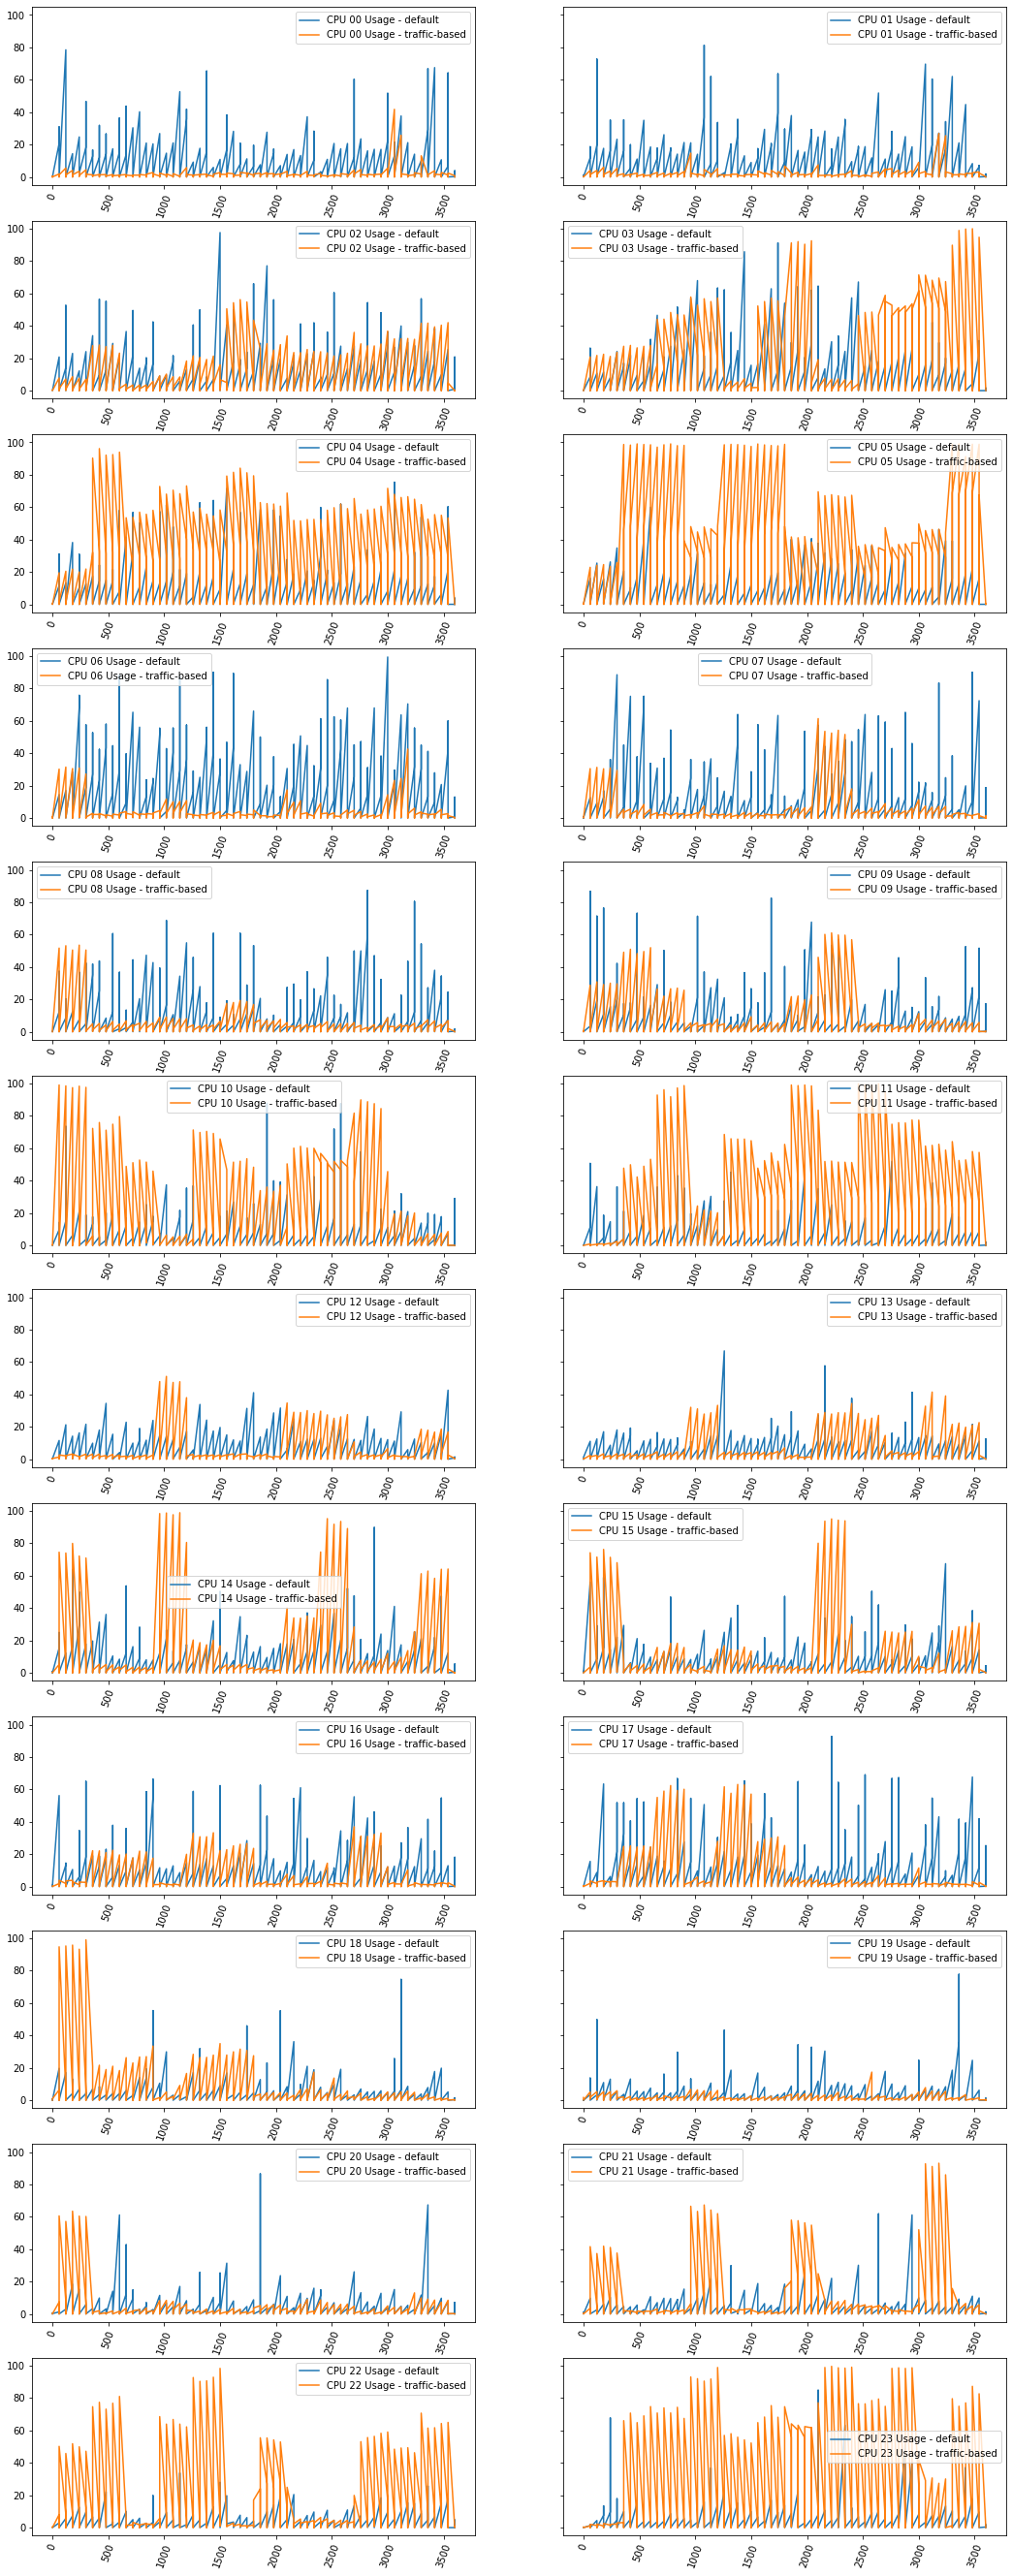

In [13]:
fig, axes = plt.subplots(12, 2, figsize=(18, 48), sharey='all')
loc_placement = "best"
x_tick_rotation = 70

for mode_idx, mode_name in enumerate(schedule_modes):
    mode_cpu_data = individual_cpu_data.loc[
        individual_cpu_data["schedule_mode"] == mode_name
    ]
    for idx, ax in enumerate(axes):
        specific_cpu_data_1 = mode_cpu_data.loc[mode_cpu_data["cpu_id"] == idx * 2]
        specific_cpu_data_2 = mode_cpu_data.loc[
            mode_cpu_data["cpu_id"] == (idx * 2 + 1)
        ]

        label_1 = specific_cpu_data_1.iloc[0]["cpu_usage_name"] + " - " + mode_name
        label_2 = specific_cpu_data_2.iloc[0]["cpu_usage_name"] + " - " + mode_name

        ax[0].plot(
            specific_cpu_data_1["rel_time"],
            specific_cpu_data_1["value"],
            "C" + str(mode_idx),
            label=label_1,
        )
        ax[0].tick_params(axis="x", rotation=x_tick_rotation)
        ax[0].legend(loc=loc_placement)

        ax[1].plot(
            specific_cpu_data_2["rel_time"],
            specific_cpu_data_2["value"],
            "C" + str(mode_idx),
            label=label_2,
        )
        ax[1].tick_params(axis="x", rotation=x_tick_rotation)
        ax[1].legend(loc=loc_placement)

plt.savefig("cpu_usage_metrics.png")

In [14]:
t_op_cpu_use, t_op_rec_in, t_op_rec_out, t_op_rec_proc = load_operator_data_from_csv(0)

# t_op_cpu_use[0] = t_op_cpu_use[0].loc[~t_op_cpu_use[0]['operator_name'].isin(['Sink: count-sink','word-count'])]

for operator_cpu_usage in t_op_cpu_use:
    drop_index = operator_cpu_usage[
        operator_cpu_usage["operator_name"].isin(["Sink: count-sink", "word-count"])
    ].index
    operator_cpu_usage.drop(drop_index, inplace=True)
    operator_cpu_usage["temp_col"] = operator_cpu_usage["operator_name"].str.partition(
        ":"
    )[2]
    operator_cpu_usage.loc[
        operator_cpu_usage["temp_col"] != "", ["operator_name"]
    ] = operator_cpu_usage["temp_col"]
    operator_cpu_usage["formatted_id"] = (
        operator_cpu_usage["operator_name"]
        + "-"
        + operator_cpu_usage["subtask_index"].astype(str)
    )
    operator_cpu_usage.drop(columns=["name", "subtask_index", "temp_col"], inplace=True)
    operator_cpu_usage["value"] = (operator_cpu_usage["value"] / 1000000000.0).round(3)

operator_ids = t_op_cpu_use[0].formatted_id.unique()
print(operator_ids)

for operator_records_in in t_op_rec_in:
    drop_index = operator_records_in[
        operator_records_in["operator_name"].isin(["word-count -> Sink: count-sink"])
    ].index
    operator_records_in.drop(drop_index, inplace=True)
    operator_records_in.loc[
        operator_records_in["operator_name"].str.partition(":")[2] != "",
        ["operator_name"],
    ] = operator_records_in["operator_name"].str.partition(":")[2]
    operator_records_in["formatted_id"] = (
        operator_records_in["operator_name"]
        + "-"
        + operator_records_in["subtask_index"].astype(str)
    )
    operator_records_in.drop(columns=["name", "subtask_index"], inplace=True)

for operator_records_out in t_op_rec_out:
    drop_index = operator_records_out[
        operator_records_out["operator_name"].isin(
            ["Sink: count-sink", "word-count -> Sink: count-sink"]
        )
    ].index
    operator_records_out.drop(drop_index, inplace=True)
    operator_records_out.loc[
        operator_records_out["operator_name"].str.partition(":")[2] != "",
        ["operator_name"],
    ] = operator_records_out["operator_name"].str.partition(":")[2]
    operator_records_out["formatted_id"] = (
        operator_records_out["operator_name"]
        + "-"
        + operator_records_out["subtask_index"].astype(str)
    )
    operator_records_out.drop(columns=["name", "subtask_index"], inplace=True)

t_op_rec_in[0].head(20)

traffic-based
Reading taskmanager_job_task_operator_currentCpuUsage_traffic-based_2021_04_05.csv into index 1 with schedule mode traffic-based
default
Reading taskmanager_job_task_operator_currentCpuUsage_default_2021_04_05.csv into index 0 with schedule mode default
traffic-based
Reading taskmanager_job_task_operator_numRecordsInPerSecond_traffic-based_2021_04_05.csv into index 1 with schedule mode traffic-based
default
Reading taskmanager_job_task_operator_numRecordsInPerSecond_default_2021_04_05.csv into index 0 with schedule mode default
traffic-based
Reading taskmanager_job_task_operator_numRecordsOutPerSecond_traffic-based_2021_04_05.csv into index 1 with schedule mode traffic-based
default
Reading taskmanager_job_task_operator_numRecordsOutPerSecond_default_2021_04_05.csv into index 0 with schedule mode default
traffic-based
Reading taskmanager_job_task_operator_numRecordsProcessedPerSecond_traffic-based_2021_04_05.csv into index 1 with schedule mode traffic-based
default
Readin

,time,count,host,job_name,operator_id,operator_name,rate,task_attempt_id,task_id,task_name,tm_id,schedule_mode,rel_time,formatted_time,formatted_id
0,2021-04-05 04:15:13.533000+00:00,224933,192.168.152.103,Word Count,0a448493b4782967b150582570326227,word-splitter,3326.716667,6b4eec1598616487fb15b0c42316ad7c,0a448493b4782967b150582570326227,word-splitter,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,word-splitter-10
1,2021-04-05 04:15:13.533000+00:00,112467,192.168.152.103,Word Count,0a448493b4782967b150582570326227,word-splitter,1663.300000,bae7494b62e4e872944445e7db0cf60a,0a448493b4782967b150582570326227,word-splitter,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,word-splitter-11
2,2021-04-05 04:15:13.533000+00:00,166516,192.168.152.103,Word Count,0a448493b4782967b150582570326227,word-splitter,2335.566667,9d4b050ed32c704f114e16bcc20f360f,0a448493b4782967b150582570326227,word-splitter,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,word-splitter-13
3,2021-04-05 04:15:13.533000+00:00,112466,192.168.152.103,Word Count,0a448493b4782967b150582570326227,word-splitter,1663.300000,279f216d3ec4599f2a467e06ae7b1e07,0a448493b4782967b150582570326227,word-splitter,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,word-splitter-9
4,2021-04-05 04:15:13.533000+00:00,2415124,192.168.152.103,Word Count,604ee7bed040266218075078a35a4449,count-sink,34957.816667,2a52e9a623aff069b1af09c85f662543,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,count-sink-7
5,2021-04-05 04:15:13.533000+00:00,2415122,192.168.152.103,Word Count,e70bbd798b564e0a50e10e343f1ac56b,word-count,34957.816667,2a52e9a623aff069b1af09c85f662543,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,word-count-7
7,2021-04-05 04:15:13.533000+00:00,0,192.168.152.103,Word Count,bc764cd8ddf7a0cff126f51c16239658,sentence-stream,0.000000,24de6b4fadfddaf1b16d77ca28999740,bc764cd8ddf7a0cff126f51c16239658,Source: sentence-stream,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,sentence-stream-0
10,2021-04-05 04:15:13.533000+00:00,364178,192.168.152.103,Word Count,604ee7bed040266218075078a35a4449,count-sink,5305.600000,252ffa216c543004b51c2746d2efd7f0,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,count-sink-0
11,2021-04-05 04:15:13.533000+00:00,0,192.168.152.103,Word Count,bc764cd8ddf7a0cff126f51c16239658,sentence-stream,0.000000,cb4708cb0e5c86a1b8597bf6aa92f3c8,bc764cd8ddf7a0cff126f51c16239658,Source: sentence-stream,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,sentence-stream-1
14,2021-04-05 04:15:13.533000+00:00,0,192.168.152.103,Word Count,bc764cd8ddf7a0cff126f51c16239658,sentence-stream,0.000000,a9e2185701d2249732a74da4ad2dd8aa,bc764cd8ddf7a0cff126f51c16239658,Source: sentence-stream,2146bdc7ad372f80afb115debf3bc385,default,0 days,04:15:13,sentence-stream-2


In [15]:
operator_placement_traffic_based = t_op_rec_in[0].groupby("formatted_id").first().reset_index()
operator_placement_traffic_based.head()

,formatted_id,time,count,host,job_name,operator_id,operator_name,rate,task_attempt_id,task_id,task_name,tm_id,schedule_mode,rel_time,formatted_time
0,count-sink-0,2021-04-05 04:15:13.533000+00:00,364178,192.168.152.103,Word Count,604ee7bed040266218075078a35a4449,count-sink,5305.600000,252ffa216c543004b51c2746d2efd7f0,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,2146bdc7ad372f80afb115debf3bc385,default,0 days 00:00:00,04:15:13
1,count-sink-1,2021-04-05 04:15:13.533000+00:00,393630,192.168.152.103,Word Count,604ee7bed040266218075078a35a4449,count-sink,5812.983333,4caabfcbd4d050adebea9034c57cb265,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,2146bdc7ad372f80afb115debf3bc385,default,0 days 00:00:00,04:15:13
2,count-sink-10,2021-04-05 04:15:13.670000+00:00,2338193,192.168.152.204,Word Count,604ee7bed040266218075078a35a4449,count-sink,33746.300000,17bcd3538ae5964b4a04782660615ee0,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,dc9bc4837cf9f5b5c0a6b349e5aad091,default,0 days 00:00:00.137000,04:15:13
3,count-sink-11,2021-04-05 04:15:13.670000+00:00,1165613,192.168.152.204,Word Count,604ee7bed040266218075078a35a4449,count-sink,16948.383333,382b775cb821946e925db3b044910999,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,dc9bc4837cf9f5b5c0a6b349e5aad091,default,0 days 00:00:00.137000,04:15:13
4,count-sink-12,2021-04-05 04:15:13.670000+00:00,1418873,192.168.152.204,Word Count,604ee7bed040266218075078a35a4449,count-sink,20570.750000,3026dbc6f57a301d296200bef5d63d96,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,dc9bc4837cf9f5b5c0a6b349e5aad091,default,0 days 00:00:00.137000,04:15:13


In [16]:
rec_out_list_data = (
    t_op_rec_out[0]
    .groupby([pd.Grouper(key="rel_time", freq="1min"), "formatted_id"])["rate"]
    .agg(lambda x: list(x))
    .reset_index()
)
rec_out_list_data["length"] = rec_out_list_data["rate"].str.len()
rec_out_list_data
# rec_proc_plot_data = (
#     t_op_rec_proc[0]
#     .groupby([pd.Grouper(key="rel_time", freq="1min"), "schedule_mode", "edge_name"])[
#         "rate"
#     ]
#     .first()
#     .reset_index()
#     .groupby(["rel_time", "schedule_mode"])
#     .sum()
#     .reset_index()
# )
# rec_proc_plot_data.head()

,rel_time,formatted_id,rate,length
0,0 days 00:00:00,sentence-stream-0,"[3524.95, 7754.016666666666]",2
1,0 days 00:00:00,sentence-stream-1,"[3722.3, 7906.0]",2
2,0 days 00:00:00,sentence-stream-2,"[3641.0833333333335, 7746.516666666666]",2
3,0 days 00:00:00,sentence-stream-3,"[3660.3, 7863.166666666667]",2
4,0 days 00:00:00,sentence-stream-4,"[3823.016666666667, 7741.666666666667]",2
...,...,...,...,...
2155,0 days 00:59:00,word-splitter-5,[31344.4],1
2156,0 days 00:59:00,word-splitter-6,[66341.18333333333],1
2157,0 days 00:59:00,word-splitter-7,[55975.46666666667],1
2158,0 days 00:59:00,word-splitter-8,[41502.7],1


In [17]:
rec_proc_list_data = (
    t_op_rec_proc[0]
    .groupby([pd.Grouper(key="rel_time", freq="1min"), "edge_name"])["rate"]
    .agg(lambda x: list(x))
    .reset_index()
)
rec_proc_list_data["length"] = rec_proc_list_data["rate"].str.len()

rec_proc_plot_data = (
    t_op_rec_proc[0]
    .groupby([pd.Grouper(key="rel_time", freq="1min"), "schedule_mode", "edge_name"])[
        "rate"
    ]
    .first()
    .reset_index()
    .groupby(["rel_time", "schedule_mode"])
    .sum()
    .reset_index()
)
rec_proc_plot_data.head()

,rel_time,schedule_mode,rate
0,0 days 00:00:00,default,257280.416667
1,0 days 00:01:00,default,615209.516667
2,0 days 00:02:00,default,616104.416667
3,0 days 00:03:00,default,606631.433333
4,0 days 00:04:00,default,607986.266667


In [18]:
t1 = t_op_rec_out[0].groupby(
    [
        pd.Grouper(key="rel_time", freq="1min"),
        "schedule_mode",
        "operator_name",
        "host",
        "formatted_id",
    ]
    )["rate"].first().reset_index()
t1

,rel_time,schedule_mode,operator_name,host,formatted_id,rate
0,0 days 00:00:00,default,sentence-stream,192.168.152.103,sentence-stream-0,3524.950000
1,0 days 00:00:00,default,sentence-stream,192.168.152.103,sentence-stream-1,3722.300000
2,0 days 00:00:00,default,sentence-stream,192.168.152.103,sentence-stream-2,3641.083333
3,0 days 00:00:00,default,sentence-stream,192.168.152.103,sentence-stream-3,3660.300000
4,0 days 00:00:00,default,sentence-stream,192.168.152.103,sentence-stream-4,3823.016667
...,...,...,...,...,...,...
2155,0 days 00:59:00,default,word-splitter,192.168.152.204,word-splitter-1,0.000000
2156,0 days 00:59:00,default,word-splitter,192.168.152.204,word-splitter-2,35523.616667
2157,0 days 00:59:00,default,word-splitter,192.168.152.204,word-splitter-3,39702.866667
2158,0 days 00:59:00,default,word-splitter,192.168.152.204,word-splitter-4,18806.700000


In [19]:
grouped_operator_rec_in = []
grouped_operator_rec_out = []
grouped_operator_rec_proc = []

for operator_records_in in t_op_rec_in:
    grouped_operator_rec_in.append(
        operator_records_in.groupby(
            [
                pd.Grouper(key="rel_time", freq="1min"),
                "schedule_mode",
                "operator_name",
                "host",
                "formatted_id",
            ]
        )["rate"]
        .first().reset_index()
        .groupby(["rel_time", "schedule_mode", "operator_name", "host"])["rate"]
        .agg(avg_rate='mean', sum_rate='sum', op_count='count')
        .reset_index()
    )

for operator_records_out in t_op_rec_out:
    grouped_operator_rec_out.append(
        operator_records_out.groupby(
            [
                pd.Grouper(key="rel_time", freq="1min"),
                "schedule_mode",
                "operator_name",
                "host",
                "formatted_id",
            ]
        )["rate"]
        .first().reset_index()
        .groupby(["rel_time", "schedule_mode", "operator_name","host"])["rate"]
        .agg(avg_rate='mean', sum_rate='sum', op_count='count')
        .reset_index()
    )

for operator_records_proc in t_op_rec_proc:
    grouped_operator_rec_proc.append(
        operator_records_proc.groupby(
            [
                pd.Grouper(key="rel_time", freq="1min"),
                "schedule_mode",
                "host",
                "edge_name"
            ]
        )["rate"]
        .first()
        .groupby(["rel_time", "schedule_mode", "host"])
        .sum()
        .reset_index()
    )

for i in range(len(grouped_operator_rec_proc)):
    grouped_operator_rec_in[i]["rel_time"] = grouped_operator_rec_in[i]["rel_time"].dt.seconds
    grouped_operator_rec_out[i]["rel_time"] = grouped_operator_rec_out[i]["rel_time"].dt.seconds
    grouped_operator_rec_proc[i]["rel_time"] = grouped_operator_rec_proc[i]["rel_time"].dt.seconds

in_operator_names = grouped_operator_rec_in[0].operator_name.unique()
out_operator_names = grouped_operator_rec_out[0].operator_name.unique()
grouped_operator_rec_out[0].head(20)

,rel_time,schedule_mode,operator_name,host,avg_rate,sum_rate,op_count
0,0,default,sentence-stream,192.168.152.103,3638.604167,29108.833333,8
1,0,default,word-count,192.168.152.103,12274.204167,98193.633333,8
2,0,default,word-count,192.168.152.204,21349.155556,128094.933333,6
3,0,default,word-splitter,192.168.152.103,19713.370833,157706.966667,8
4,0,default,word-splitter,192.168.152.204,11744.125000,70464.750000,6
5,60,default,sentence-stream,192.168.152.103,8334.502083,66676.016667,8
6,60,default,word-count,192.168.152.103,30027.100000,240216.800000,8
7,60,default,word-count,192.168.152.204,51128.294444,306769.766667,6
8,60,default,word-splitter,192.168.152.103,48297.112500,386376.900000,8
9,60,default,word-splitter,192.168.152.204,27026.100000,162156.600000,6


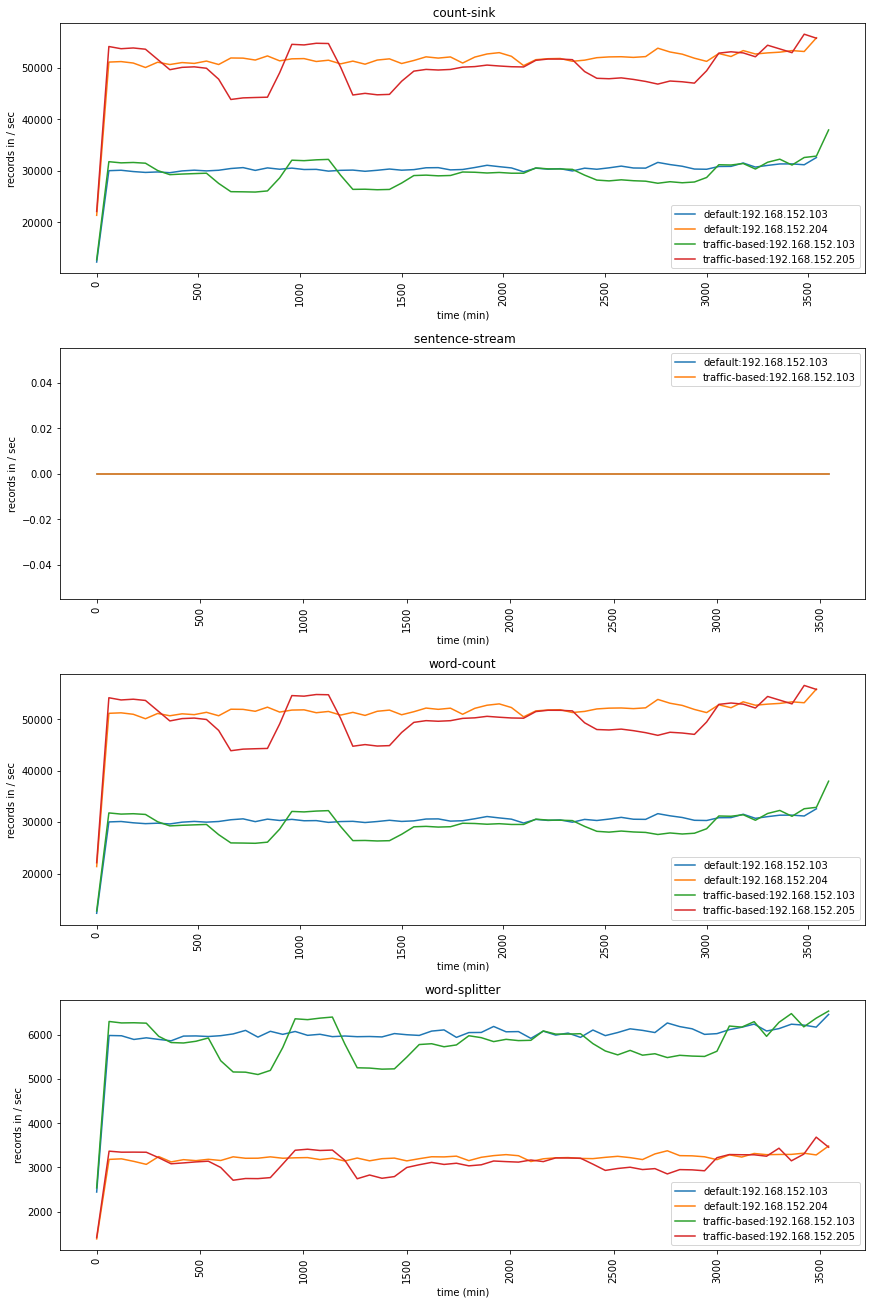

In [20]:
fig, axes = plt.subplots(
    len(in_operator_names), figsize=(12, 18), constrained_layout=True
)
x_tick_rotation = 90

for idx, ax in enumerate(axes):
    label_1 = in_operator_names[idx]
    ax.set_title(label_1)
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_in_dataset in grouped_operator_rec_in:
        specific_op_rec_in = grp_op_rec_in_dataset.loc[
            grp_op_rec_in_dataset["operator_name"] == in_operator_names[idx]
        ]
        schedule_mode = specific_op_rec_in["schedule_mode"].unique()[0]
        unique_hosts = specific_op_rec_in["host"].unique()
        for current_host in unique_hosts:
            specific_op_rec_in_per_host = specific_op_rec_in.loc[
                specific_op_rec_in["host"] == current_host
            ]
            ax.plot(
                specific_op_rec_in_per_host["rel_time"],
                specific_op_rec_in_per_host["avg_rate"],
                label=schedule_mode + ":" + current_host
            )
    ax.set_xlabel("time (min)")
    ax.set_ylabel("records in / sec")

    ax.legend(loc="best")

plt.savefig("operator_metrics_in.png")

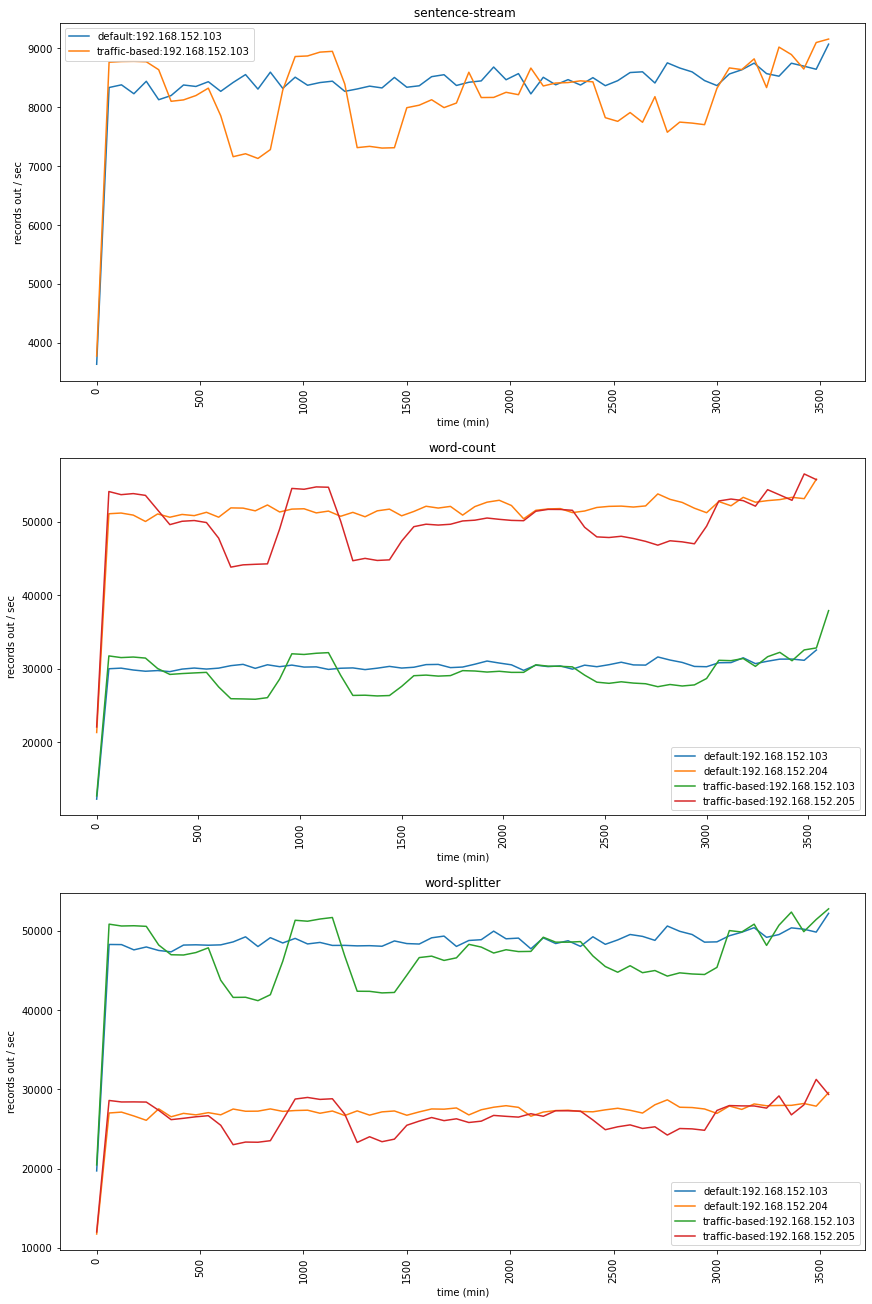

In [21]:
fig, axes = plt.subplots(
    len(out_operator_names), figsize=(12, 18), constrained_layout=True
)
loc_placement = "upper right"
x_tick_rotation = 90

for idx, ax in enumerate(axes):
    label_1 = out_operator_names[idx]
    ax.set_title(label_1)
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_out_dataset in grouped_operator_rec_out:
        specific_op_rec_out = grp_op_rec_out_dataset.loc[
            grp_op_rec_out_dataset["operator_name"] == out_operator_names[idx]
        ]
        schedule_mode = specific_op_rec_out["schedule_mode"].unique()[0]
        unique_hosts = specific_op_rec_out["host"].unique()
        for current_host in unique_hosts:
            specific_op_rec_out_per_host = specific_op_rec_out.loc[
                specific_op_rec_out["host"] == current_host
            ]
            ax.plot(
                specific_op_rec_out_per_host["rel_time"],
                specific_op_rec_out_per_host["avg_rate"],
                label=schedule_mode + ":" + current_host
            )

    ax.set_xlabel("time (min)")
    ax.set_ylabel("records out / sec")
    ax.legend(loc="best")

plt.savefig("operator_metrics_out.png")

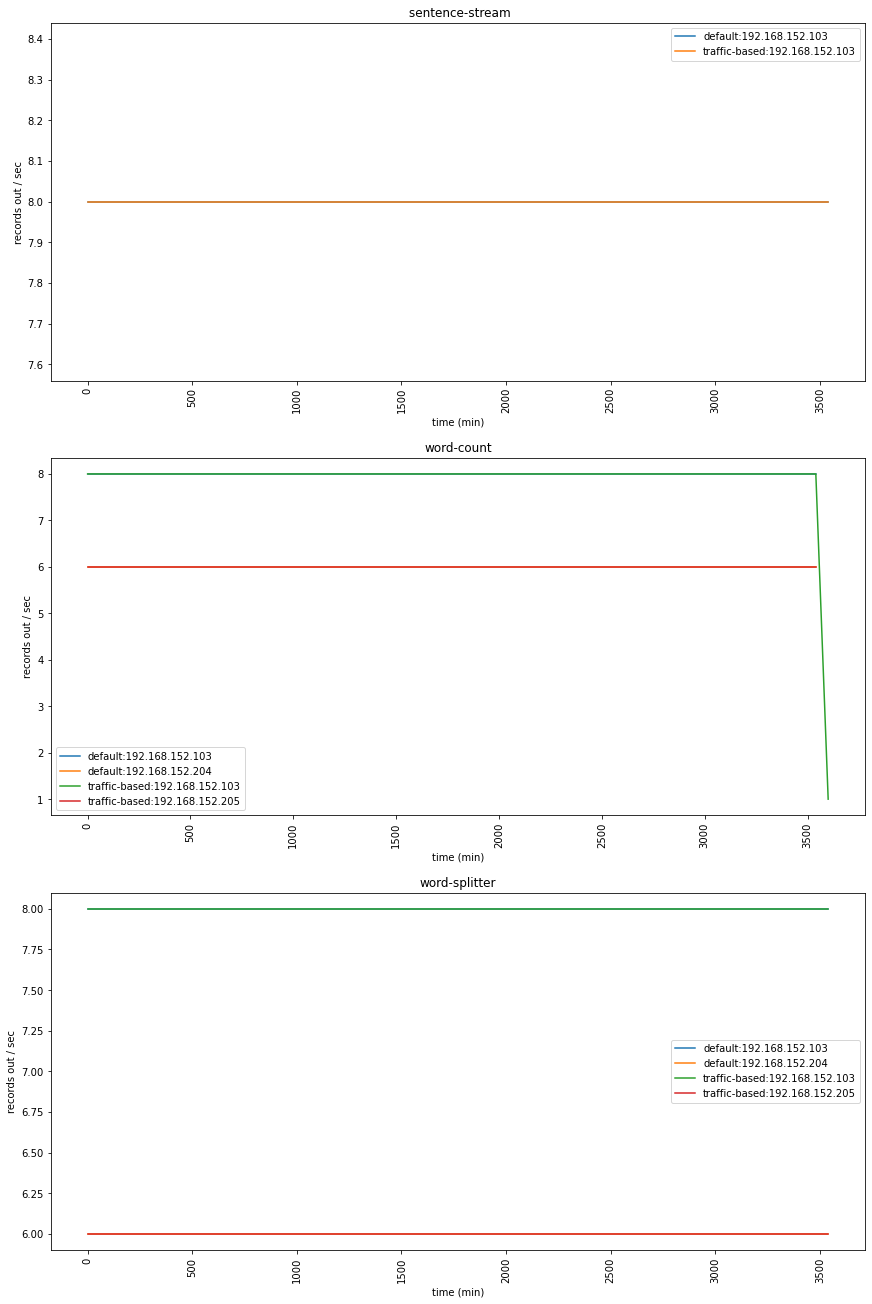

In [22]:

fig, axes = plt.subplots(
    len(out_operator_names), figsize=(12, 18), constrained_layout=True
)
loc_placement = "upper right"
x_tick_rotation = 90

for idx, ax in enumerate(axes):
    label_1 = out_operator_names[idx]
    ax.set_title(label_1)
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_out_dataset in grouped_operator_rec_out:
        specific_op_rec_out = grp_op_rec_out_dataset.loc[
            grp_op_rec_out_dataset["operator_name"] == out_operator_names[idx]
        ]
        schedule_mode = specific_op_rec_out["schedule_mode"].unique()[0]
        unique_hosts = specific_op_rec_out["host"].unique()
        for current_host in unique_hosts:
            specific_op_rec_out_per_host = specific_op_rec_out.loc[
                specific_op_rec_out["host"] == current_host
            ]
            ax.plot(
                specific_op_rec_out_per_host["rel_time"],
                specific_op_rec_out_per_host["op_count"],
                label=schedule_mode + ":" + current_host
            )

    ax.set_xlabel("time (min)")
    ax.set_ylabel("records out / sec")
    ax.legend(loc="best")

plt.savefig("operator_metrics_out_count.png")


In [23]:
grouped_operator_rec_proc[0]

,rel_time,schedule_mode,host,rate
0,0,default,192.168.152.103,186815.666667
1,0,default,192.168.152.204,70464.750000
2,60,default,192.168.152.103,453052.916667
3,60,default,192.168.152.204,162156.600000
4,120,default,192.168.152.103,453294.050000
...,...,...,...,...
115,3420,default,192.168.152.204,169342.500000
116,3480,default,192.168.152.103,468018.150000
117,3480,default,192.168.152.204,167314.966667
118,3540,default,192.168.152.103,490378.733333


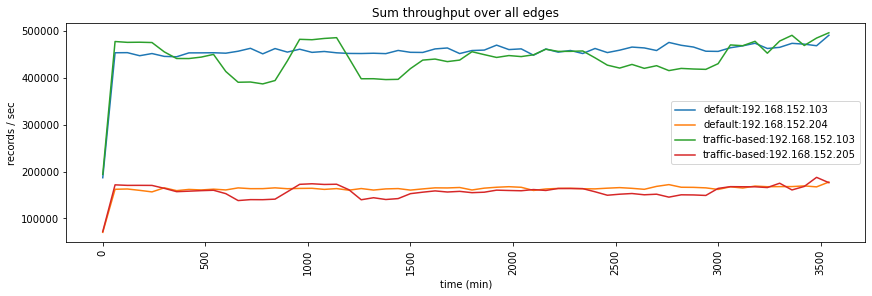

In [24]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
x_tick_rotation = 90

ax.set_title("Sum throughput over all edges")
ax.tick_params(axis="x", rotation=x_tick_rotation)
for grp_op_rec_proc_dataset in grouped_operator_rec_proc:
    schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
    unique_hosts = grp_op_rec_proc_dataset["host"].unique()
    for current_host in unique_hosts:
        specific_op_rec_proc_per_host = grp_op_rec_proc_dataset.loc[
            grp_op_rec_proc_dataset["host"] == current_host
        ]
        ax.plot(
            specific_op_rec_proc_per_host["rel_time"],
            specific_op_rec_proc_per_host["rate"],
            label=schedule_mode + ":" + current_host
        )

    ax.set_xlabel("time (min)")
    ax.set_ylabel("records / sec")

ax.legend(loc="best")

plt.savefig("operator_metrics_proc.png")
plt.savefig("operator_metrics_proc.pdf")

In [25]:
grouped_operator_rec_proc[0].head()

,rel_time,schedule_mode,host,rate
0,0,default,192.168.152.103,186815.666667
1,0,default,192.168.152.204,70464.750000
2,60,default,192.168.152.103,453052.916667
3,60,default,192.168.152.204,162156.600000
4,120,default,192.168.152.103,453294.050000


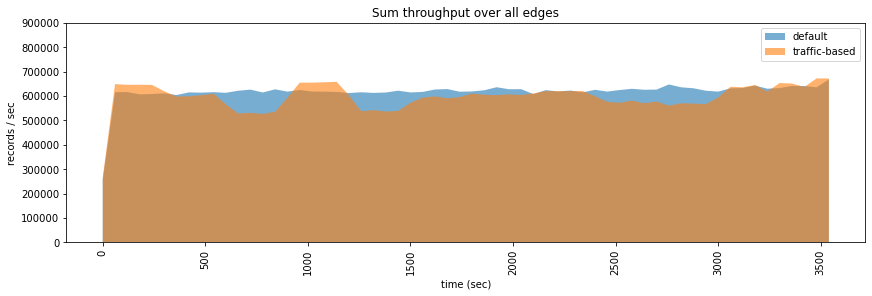

In [32]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
x_tick_rotation = 90

ax.set_title("Sum throughput over all edges")
ax.tick_params(axis="x", rotation=x_tick_rotation)
for grp_op_rec_proc_dataset in grouped_operator_rec_proc:
    schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
    specific_op_rec_proc_dataset = grp_op_rec_proc_dataset\
        .groupby(["rel_time","schedule_mode"])\
        .sum().reset_index()
    ax.fill_between(
        specific_op_rec_proc_dataset["rel_time"],
        specific_op_rec_proc_dataset["rate"],
        label=schedule_mode,
        alpha=0.6,
    )
    ax.set_xlabel("time (sec)")
    ax.set_ylabel("records / sec")

ax.legend(loc="best")
plt.ylim(0, 900000)

plt.savefig("operator_metrics_proc_short_y.png")
plt.savefig("operator_metrics_proc_short_y.pdf")

In [33]:
for grp_op_rec_proc_dataset in grouped_operator_rec_proc:
    specific_op_rec_proc_dataset = grp_op_rec_proc_dataset\
        .groupby(["rel_time","schedule_mode"])\
        .sum().reset_index()
    schedule_mode = specific_op_rec_proc_dataset["schedule_mode"].unique()[0]
    print(
        "AUC ({}) : \t{:,.2f}".format(
            schedule_mode,
            auc(
                specific_op_rec_proc_dataset["rel_time"],
                specific_op_rec_proc_dataset["rate"],
            ),
        )
    )

AUC (default) : 	2,192,973,368.50
AUC (traffic-based) : 	2,117,871,246.50


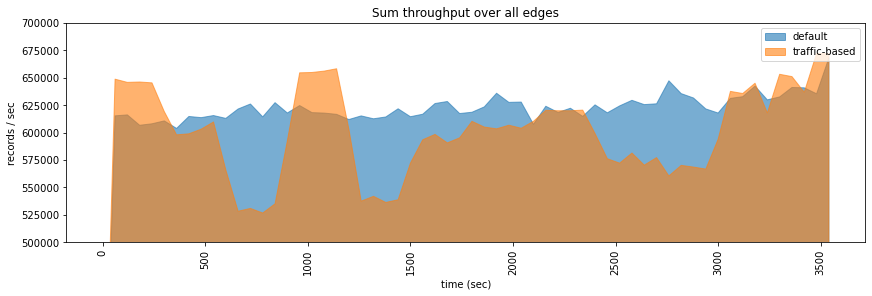

In [35]:
if len(grouped_operator_rec_proc) > 1:
    fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
    loc_placement = "upper right"
    x_tick_rotation = 90

    ax.set_title("Sum throughput over all edges")
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_proc_dataset in [grouped_operator_rec_proc[i] for i in [0, 1]]:
        schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
        specific_op_rec_proc_dataset = grp_op_rec_proc_dataset\
            .groupby(["rel_time","schedule_mode"])\
            .sum().reset_index()
        mode_color = "C0"
        if schedule_mode == "traffic-based":
            mode_color = "C1"
        elif schedule_mode == "Q-actor-critic":
            mode_color = "C2"
        elif schedule_mode == "actor-critic-NN":
            mode_color = "C3"
        ax.fill_between(
            specific_op_rec_proc_dataset["rel_time"],
            specific_op_rec_proc_dataset["rate"],
            label=schedule_mode,
            alpha=0.6,
            color=mode_color,
        )
        ax.set_xlabel("time (sec)")
        ax.set_ylabel("records / sec")

    ax.legend(loc="best")
    plt.ylim(500000, 700000)

    plt.savefig("operator_metrics_proc_short_y_traffic_based.png")
    plt.savefig("operator_metrics_proc_short_y_traffic_based.pdf")

In [29]:
if len(grouped_operator_rec_proc) > 2:
    fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
    loc_placement = "upper right"
    x_tick_rotation = 90

    ax.set_title("Sum throughput over all edges")
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_proc_dataset in [grouped_operator_rec_proc[i] for i in [0, 2]]:
        schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
        mode_color = "C0"
        if schedule_mode == "traffic-based":
            mode_color = "C1"
        elif schedule_mode == "Q-actor-critic":
            mode_color = "C2"
        elif schedule_mode == "actor-critic-NN":
            mode_color = "C3"
        ax.fill_between(
            grp_op_rec_proc_dataset["rel_time"],
            grp_op_rec_proc_dataset["rate"],
            label=schedule_mode,
            alpha=0.6,
            color=mode_color,
        )
        ax.set_xlabel("time (min)")
        ax.set_ylabel("records / sec")

    ax.legend(loc="best")
    plt.ylim(300000, 450000)

    plt.savefig("operator_metrics_proc_short_y_drl_based.pdf")

In [30]:
if len(grouped_operator_rec_proc) > 3:
    fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
    loc_placement = "upper right"
    x_tick_rotation = 90

    ax.set_title("Sum throughput over all edges")
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_proc_dataset in [grouped_operator_rec_proc[i] for i in [0, 3]]:
        schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
        mode_color = "C0"
        if schedule_mode == "traffic-based":
            mode_color = "C1"
        elif schedule_mode == "Q-actor-critic":
            mode_color = "C2"
        elif schedule_mode == "actor-critic-NN":
            mode_color = "C3"
        ax.fill_between(
            grp_op_rec_proc_dataset["rel_time"],
            grp_op_rec_proc_dataset["rate"],
            label=schedule_mode,
            alpha=0.6,
            color=mode_color,
        )
        ax.set_xlabel("time (min)")
        ax.set_ylabel("records / sec")

    ax.legend(loc="best")
    plt.ylim(300000, 450000)

    plt.savefig("operator_metrics_proc_short_y_adaptive.pdf")

In [31]:
print("Done.")

Done.
